# This notebook does data cartography for a binary classification task

It uses sst2 from glue as a placeholder. Please insert your own data.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1gWdneg4xRBC8hr_kc5fvaK5yb9DWAUnj?usp=sharing)

In [ ]:
!pip install transformers sentencepiece datasets git+https://github.com/huggingface/accelerate.git 

# Training file

This is taken mostly from [run_glue_no_trainer.py](https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue_no_trainer.py) with a little inserted into the training loop which saves the predictions, labels, and other information needed to do dataset cartography.

In [ ]:
%%writefile glue_cartography.py

import argparse
import json
import logging
import math
import os
import random
from pathlib import Path
from typing import List

import datasets
import torch
from datasets import load_dataset, load_metric
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import pandas as pd

import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from huggingface_hub import Repository
from transformers import (
    AdamW,
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    PretrainedConfig,
    SchedulerType,
    default_data_collator,
    get_scheduler,
)
from transformers.utils import get_full_repo_name
from transformers.utils.versions import require_version


logger = get_logger(__name__)

require_version("datasets>=1.8.0", "To fix: pip install -r examples/pytorch/text-classification/requirements.txt")

task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}


def log_training_dynamics(output_dir: os.path,
                          epoch: int,
                          train_ids: List[int],
                          train_logits: List[List[float]],
                          train_labels: List[int]):
  """
  Save training dynamics (logits) from given epoch as records of a `.jsonl` file.
  """
  td_df = pd.DataFrame({"guid": train_ids,
                        f"logits_epoch_{epoch}": train_logits,
                        "gold": train_labels})

  logging_dir = os.path.join(output_dir, f"training_dynamics")
  # Create directory for logging training dynamics, if it doesn't already exist.
  if not os.path.exists(logging_dir):
    os.makedirs(logging_dir)
  epoch_file_name = os.path.join(logging_dir, f"dynamics_epoch_{epoch}.jsonl")
  td_df.to_json(epoch_file_name, lines=True, orient="records")
  logger.info(f"Training Dynamics logged to {epoch_file_name}")

def parse_args():
    parser = argparse.ArgumentParser(description="Finetune a transformers model on a text classification task")
    parser.add_argument(
        "--task_name",
        type=str,
        default=None,
        help="The name of the glue task to train on.",
        choices=list(task_to_keys.keys()),
    )
    parser.add_argument(
        "--train_file", type=str, default=None, help="A csv or a json file containing the training data."
    )
    parser.add_argument(
        "--validation_file", type=str, default=None, help="A csv or a json file containing the validation data."
    )
    parser.add_argument(
        "--max_length",
        type=int,
        default=128,
        help=(
            "The maximum total input sequence length after tokenization. Sequences longer than this will be truncated,"
            " sequences shorter will be padded if `--pad_to_max_lengh` is passed."
        ),
    )
    parser.add_argument(
        "--pad_to_max_length",
        action="store_true",
        help="If passed, pad all samples to `max_length`. Otherwise, dynamic padding is used.",
    )
    parser.add_argument(
        "--model_name_or_path",
        type=str,
        help="Path to pretrained model or model identifier from huggingface.co/models.",
        required=True,
    )
    parser.add_argument(
        "--use_slow_tokenizer",
        action="store_true",
        help="If passed, will use a slow tokenizer (not backed by the 🤗 Tokenizers library).",
    )
    parser.add_argument(
        "--per_device_train_batch_size",
        type=int,
        default=8,
        help="Batch size (per device) for the training dataloader.",
    )
    parser.add_argument(
        "--per_device_eval_batch_size",
        type=int,
        default=8,
        help="Batch size (per device) for the evaluation dataloader.",
    )
    parser.add_argument(
        "--learning_rate",
        type=float,
        default=5e-5,
        help="Initial learning rate (after the potential warmup period) to use.",
    )
    parser.add_argument("--weight_decay", type=float, default=0.0, help="Weight decay to use.")
    parser.add_argument("--num_train_epochs", type=int, default=3, help="Total number of training epochs to perform.")
    parser.add_argument(
        "--max_train_steps",
        type=int,
        default=None,
        help="Total number of training steps to perform. If provided, overrides num_train_epochs.",
    )
    parser.add_argument(
        "--gradient_accumulation_steps",
        type=int,
        default=1,
        help="Number of updates steps to accumulate before performing a backward/update pass.",
    )
    parser.add_argument(
        "--lr_scheduler_type",
        type=SchedulerType,
        default="linear",
        help="The scheduler type to use.",
        choices=["linear", "cosine", "cosine_with_restarts", "polynomial", "constant", "constant_with_warmup"],
    )
    parser.add_argument(
        "--num_warmup_steps", type=int, default=0, help="Number of steps for the warmup in the lr scheduler."
    )
    parser.add_argument("--output_dir", type=str, default=None, help="Where to store the final model.")
    parser.add_argument("--seed", type=int, default=None, help="A seed for reproducible training.")
    parser.add_argument(
        "--with_tracking",
        action="store_true",
        help="Whether to load in all available experiment trackers from the environment and use them for logging.",
    )
    parser.add_argument("--mixed_precision", type=str, default=None, help="fp16, bf16, None")
    args = parser.parse_args()

    # Sanity checks
    if args.task_name is None and args.train_file is None and args.validation_file is None:
        raise ValueError("Need either a task name or a training/validation file.")
    else:
        if args.train_file is not None:
            extension = args.train_file.split(".")[-1]
            assert extension in ["csv", "json"], "`train_file` should be a csv or a json file."
        if args.validation_file is not None:
            extension = args.validation_file.split(".")[-1]
            assert extension in ["csv", "json"], "`validation_file` should be a csv or a json file."

    return args


def main():
    args = parse_args()

    # Initialize the accelerator. We will let the accelerator handle device placement for us in this example.
    # If we're using tracking, we also need to initialize it here and it will pick up all supported trackers in the environment
    accelerator = Accelerator(log_with="all", logging_dir=args.output_dir, mixed_precision=args.mixed_precision) if args.with_tracking else Accelerator()
    # Make one log on every process with the configuration for debugging.
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )
    logger.info(accelerator.state, main_process_only=False)
    if accelerator.is_local_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    # If passed along, set the training seed now.
    if args.seed is not None:
        set_seed(args.seed)

    # Get the datasets: you can either provide your own CSV/JSON training and evaluation files (see below)
    # or specify a GLUE benchmark task (the dataset will be downloaded automatically from the datasets Hub).

    # For CSV/JSON files, this script will use as labels the column called 'label' and as pair of sentences the
    # sentences in columns called 'sentence1' and 'sentence2' if such column exists or the first two columns not named
    # label if at least two columns are provided.

    # If the CSVs/JSONs contain only one non-label column, the script does single sentence classification on this
    # single column. You can easily tweak this behavior (see below)

    # In distributed training, the load_dataset function guarantee that only one local process can concurrently
    # download the dataset.
    if args.task_name is not None:
        # Downloading and loading a dataset from the hub.
        raw_datasets = load_dataset("glue", args.task_name)
    else:
        # Loading the dataset from local csv or json file.
        data_files = {}
        if args.train_file is not None:
            data_files["train"] = args.train_file
        if args.validation_file is not None:
            data_files["validation"] = args.validation_file
        extension = (args.train_file if args.train_file is not None else args.valid_file).split(".")[-1]
        raw_datasets = load_dataset(extension, data_files=data_files)
    # See more about loading any type of standard or custom dataset at
    # https://huggingface.co/docs/datasets/loading_datasets.html.

    # Labels
    if args.task_name is not None:
        is_regression = args.task_name == "stsb"
        if not is_regression:
            label_list = raw_datasets["train"].features["label"].names
            num_labels = len(label_list)
        else:
            num_labels = 1
    else:
        # Trying to have good defaults here, don't hesitate to tweak to your needs.
        is_regression = raw_datasets["train"].features["label"].dtype in ["float32", "float64"]
        if is_regression:
            num_labels = 1
        else:
            # A useful fast method:
            # https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.unique
            label_list = raw_datasets["train"].unique("label")
            label_list.sort()  # Let's sort it for determinism
            num_labels = len(label_list)

    # Load pretrained model and tokenizer
    #
    # In distributed training, the .from_pretrained methods guarantee that only one local process can concurrently
    # download model & vocab.
    config = AutoConfig.from_pretrained(args.model_name_or_path, num_labels=num_labels, finetuning_task=args.task_name)
    tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_path, use_fast=not args.use_slow_tokenizer)
    model = AutoModelForSequenceClassification.from_pretrained(
        args.model_name_or_path,
        from_tf=bool(".ckpt" in args.model_name_or_path),
        config=config,
    )

    # Preprocessing the datasets
    if args.task_name is not None:
        sentence1_key, sentence2_key = task_to_keys[args.task_name]
    else:
        # Again, we try to have some nice defaults but don't hesitate to tweak to your use case.
        non_label_column_names = [name for name in raw_datasets["train"].column_names if name != "label"]
        if "sentence1" in non_label_column_names and "sentence2" in non_label_column_names:
            sentence1_key, sentence2_key = "sentence1", "sentence2"
        else:
            if len(non_label_column_names) >= 2:
                sentence1_key, sentence2_key = non_label_column_names[:2]
            else:
                sentence1_key, sentence2_key = non_label_column_names[0], None

    # Some models have set the order of the labels to use, so let's make sure we do use it.
    label_to_id = None
    if (
        model.config.label2id != PretrainedConfig(num_labels=num_labels).label2id
        and args.task_name is not None
        and not is_regression
    ):
        # Some have all caps in their config, some don't.
        label_name_to_id = {k.lower(): v for k, v in model.config.label2id.items()}
        if list(sorted(label_name_to_id.keys())) == list(sorted(label_list)):
            logger.info(
                f"The configuration of the model provided the following label correspondence: {label_name_to_id}. "
                "Using it!"
            )
            label_to_id = {i: label_name_to_id[label_list[i]] for i in range(num_labels)}
        else:
            logger.warning(
                "Your model seems to have been trained with labels, but they don't match the dataset: ",
                f"model labels: {list(sorted(label_name_to_id.keys()))}, dataset labels: {list(sorted(label_list))}."
                "\nIgnoring the model labels as a result.",
            )
    elif args.task_name is None:
        label_to_id = {v: i for i, v in enumerate(label_list)}

    if label_to_id is not None:
        model.config.label2id = label_to_id
        model.config.id2label = {id: label for label, id in config.label2id.items()}
    elif args.task_name is not None and not is_regression:
        model.config.label2id = {l: i for i, l in enumerate(label_list)}
        model.config.id2label = {id: label for label, id in config.label2id.items()}

    padding = "max_length" if args.pad_to_max_length else False

    def preprocess_function(examples):
        # Tokenize the texts
        texts = (
            (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
        )
        result = tokenizer(*texts, padding=padding, max_length=args.max_length, truncation=True)

        if "label" in examples:
            if label_to_id is not None:
                # Map labels to IDs (not necessary for GLUE tasks)
                result["labels"] = [label_to_id[l] for l in examples["label"]]
            else:
                # In all cases, rename the column to labels because the model will expect that.
                result["labels"] = examples["label"]

        result["id"] = examples["idx"]

        return result

    with accelerator.main_process_first():
        processed_datasets = raw_datasets.map(
            preprocess_function,
            batched=True,
            remove_columns=raw_datasets["train"].column_names,
            desc="Running tokenizer on dataset",
        )
    

    train_dataset = processed_datasets["train"]
    eval_dataset = processed_datasets["validation_matched" if args.task_name == "mnli" else "validation"]

    # Log a few random samples from the training set:
    for index in random.sample(range(len(train_dataset)), 3):
        logger.info(f"Sample {index} of the training set: {train_dataset[index]}.")

    # DataLoaders creation:
    if args.pad_to_max_length:
        # If padding was already done ot max length, we use the default data collator that will just convert everything
        # to tensors.
        data_collator = default_data_collator
    else:
        # Otherwise, `DataCollatorWithPadding` will apply dynamic padding for us (by padding to the maximum length of
        # the samples passed). When using mixed precision, we add `pad_to_multiple_of=8` to pad all tensors to multiple
        # of 8s, which will enable the use of Tensor Cores on NVIDIA hardware with compute capability >= 7.5 (Volta).
        data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=(8 if accelerator.use_fp16 else None))

    train_dataloader = DataLoader(
        train_dataset, shuffle=True, collate_fn=data_collator, batch_size=args.per_device_train_batch_size
    )
    eval_dataloader = DataLoader(eval_dataset, collate_fn=data_collator, batch_size=args.per_device_eval_batch_size)

    # Optimizer
    # Split weights in two groups, one with weight decay and the other not.
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate)

    # Scheduler and math around the number of training steps.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    if args.max_train_steps is None:
        args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
    else:
        args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    lr_scheduler = get_scheduler(
        name=args.lr_scheduler_type,
        optimizer=optimizer,
        num_warmup_steps=args.num_warmup_steps,
        num_training_steps=args.max_train_steps,
    )

    # Prepare everything with our `accelerator`.
    model, optimizer, train_dataloader, eval_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, eval_dataloader, lr_scheduler
    )

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch

    # We need to initialize the trackers we use, and also store our configuration
    if args.with_tracking:
        experiment_config = vars(args)
        # TensorBoard cannot log Enums, need the raw value
        experiment_config["lr_scheduler_type"] = experiment_config["lr_scheduler_type"].value
        accelerator.init_trackers("glue_no_trainer", experiment_config)

    # Get the metric function
    if args.task_name is not None:
        metric = load_metric("glue", args.task_name)
    else:
        metric = load_metric("accuracy")

    # Train!
    total_batch_size = args.per_device_train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Num Epochs = {args.num_train_epochs}")
    logger.info(f"  Instantaneous batch size per device = {args.per_device_train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
    completed_steps = 0
    starting_epoch = 0


    for epoch in range(starting_epoch, args.num_train_epochs):
        model.train()
        if args.with_tracking:
            total_loss = 0

        logits = []
        labels = []
        epoch_ids = []


        for step, batch in enumerate(train_dataloader):
            
            batch_ids = batch.pop("id")
            outputs = model(**batch)
            loss = outputs.loss
            # We keep track of the loss at each epoch
            if args.with_tracking:
                total_loss += loss.detach().float()
            loss = loss / args.gradient_accumulation_steps
            accelerator.backward(loss)
            if step % args.gradient_accumulation_steps == 0 or step == len(train_dataloader) - 1:
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
                progress_bar.update(1)
                completed_steps += 1

            if completed_steps >= args.max_train_steps:
                break

            logits.extend(outputs.logits.view(-1, outputs.logits.shape[-1]).detach().cpu().tolist())
            labels.extend(batch["labels"].view(-1, 1).detach().cpu().tolist())
            epoch_ids.extend(batch_ids.view(-1, 1).detach().cpu().tolist())
        
        log_training_dynamics(output_dir=args.output_dir,
                          epoch=epoch,
                          train_ids=epoch_ids,
                          train_logits=logits,
                          train_labels=labels)


        model.eval()
        samples_seen = 0
        for step, batch in enumerate(eval_dataloader):
            with torch.no_grad():
                del batch["id"]
                outputs = model(**batch)
            predictions = outputs.logits.argmax(dim=-1) if not is_regression else outputs.logits.squeeze()
            predictions, references = accelerator.gather((predictions, batch["labels"]))
            # If we are in a multiprocess environment, the last batch has duplicates
            if accelerator.num_processes > 1:
                if step == len(eval_dataloader):
                    predictions = predictions[: len(eval_dataloader.dataset) - samples_seen]
                    references = references[: len(eval_dataloader.dataset) - samples_seen]
                else:
                    samples_seen += references.shape[0]
            metric.add_batch(
                predictions=predictions,
                references=references,
            )

        eval_metric = metric.compute()
        logger.info(f"epoch {epoch}: {eval_metric}")

        if args.with_tracking:
            accelerator.log(
                {
                    "accuracy" if args.task_name is not None else "glue": eval_metric,
                    "train_loss": total_loss,
                    "epoch": epoch,
                    "step": completed_steps,
                },
            )


    if args.task_name == "mnli":
        # Final evaluation on mismatched validation set
        eval_dataset = processed_datasets["validation_mismatched"]
        eval_dataloader = DataLoader(
            eval_dataset, collate_fn=data_collator, batch_size=args.per_device_eval_batch_size
        )
        eval_dataloader = accelerator.prepare(eval_dataloader)

        model.eval()
        for step, batch in enumerate(eval_dataloader):
            outputs = model(**batch)
            predictions = outputs.logits.argmax(dim=-1)
            metric.add_batch(
                predictions=accelerator.gather(predictions),
                references=accelerator.gather(batch["labels"]),
            )

        eval_metric = metric.compute()
        logger.info(f"mnli-mm: {eval_metric}")

if __name__ == "__main__":
    main()

Writing glue_cartography.py


# Running the script

In [ ]:
%env TASK_NAME=sst2
!echo $TASK_NAME

!python glue_cartography.py \
  --model_name_or_path microsoft/xtremedistil-l6-h256-uncased \
  --task_name $TASK_NAME \
  --max_length 96 \
  --per_device_train_batch_size 512 \
  --learning_rate 5e-5 \
  --num_train_epochs 5 \
  --output_dir /tmp/$TASK_NAME/ \
  --mixed_precision fp16

env: TASK_NAME=sst2
sst2
05/09/2022 13:24:12 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda
Mixed precision type: no

05/09/2022 13:24:13 - WARNING - datasets.builder - Reusing dataset glue (/root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100% 3/3 [00:00<00:00, 903.75it/s]
loading configuration file https://huggingface.co/microsoft/xtremedistil-l6-h256-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e545113a9b5e643083a51ba645bed76c8df28ab46010b1ae39650ce7c668fe0c.142acdac8e7631616b334d09a95700d181a33a84fd7eb9ab46593634d0873dda
Model config BertConfig {
  "_name_or_path": "microsoft/xtremedistil-l6-h256-uncased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "finetuning_task": "sst2",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hi

# Cartography helper functions

In [ ]:
import json
import logging
import numpy as np
import os
import pandas as pd
import tqdm

from typing import List

def read_training_dynamics(model_dir: os.path,
                           strip_last: bool = False,
                           id_field: str = "guid",
                           burn_out: int = None):
  """
  Given path to logged training dynamics, merge stats across epochs.
  Returns:
  - Dict between ID of a train instances and its gold label, and the list of logits across epochs.
  """
  train_dynamics = {}

  td_dir = os.path.join(model_dir, "training_dynamics")
  num_epochs = len([f for f in os.listdir(td_dir) if os.path.isfile(os.path.join(td_dir, f))])
  if burn_out:
    num_epochs = burn_out

  print(f"Reading {num_epochs} files from {td_dir} ...")
  for epoch_num in tqdm.tqdm(range(num_epochs)):
    epoch_file = os.path.join(td_dir, f"dynamics_epoch_{epoch_num}.jsonl")
    assert os.path.exists(epoch_file)

    with open(epoch_file, "r") as infile:
      for line in infile:
        record = json.loads(line.strip())
        guid = record[id_field] if not strip_last else record[id_field][:-1]
        guid = guid[0]
        if guid not in train_dynamics:
          assert epoch_num == 0
          train_dynamics[guid] = {"gold": record["gold"][0], "logits": []}
        train_dynamics[guid]["logits"].append(record[f"logits_epoch_{epoch_num}"])

  print(f"Read training dynamics for {len(train_dynamics)} train instances.")
  return train_dynamics

In [ ]:
import argparse
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
import tqdm

from collections import defaultdict
from typing import List

def compute_forgetfulness(correctness_trend: List[float]) -> int:
  """
  Given a epoch-wise trend of train predictions, compute frequency with which
  an example is forgotten, i.e. predicted incorrectly _after_ being predicted correctly.
  Based on: https://arxiv.org/abs/1812.05159
  """
  if not any(correctness_trend):  # Example is never predicted correctly, or learnt!
      return 1000
  learnt = False  # Predicted correctly in the current epoch.
  times_forgotten = 0
  for is_correct in correctness_trend:
    if (not learnt and not is_correct) or (learnt and is_correct):
      # nothing changed.
      continue
    elif learnt and not is_correct:
      # Forgot after learning at some point!
      learnt = False
      times_forgotten += 1
    elif not learnt and is_correct:
      # Learnt!
      learnt = True
  return times_forgotten


def compute_correctness(trend: List[float]) -> float:
  """
  Aggregate #times an example is predicted correctly during all training epochs.
  """
  return sum(trend)


def compute_train_dy_metrics(training_dynamics, args, ):
  """
  Given the training dynamics (logits for each training instance across epochs), compute metrics
  based on it, for data map coorodinates.
  Computed metrics are: confidence, variability, correctness, forgetfulness, threshold_closeness---
  the last two being baselines from prior work
  (Example Forgetting: https://arxiv.org/abs/1812.05159 and
   Active Bias: https://arxiv.org/abs/1704.07433 respectively).
  Returns:
  - DataFrame with these metrics.
  - DataFrame with more typical training evaluation metrics, such as accuracy / loss.
  """
  confidence_ = {}
  variability_ = {}
  threshold_closeness_ = {}
  correctness_ = {}
  forgetfulness_ = {}

  # Functions to be applied to the data.
  variability_func = lambda conf: np.std(conf)
  if args.include_ci:  # Based on prior work on active bias (https://arxiv.org/abs/1704.07433)
    variability_func = lambda conf: np.sqrt(np.var(conf) + np.var(conf) * np.var(conf) / (len(conf)-1))
  threshold_closeness_func = lambda conf: conf * (1 - conf)

  loss = torch.nn.CrossEntropyLoss()

  num_tot_epochs = len(list(training_dynamics.values())[0]["logits"])
  if args.burn_out < num_tot_epochs:
    print(f"Computing training dynamics. Burning out at {args.burn_out} of {num_tot_epochs}. ")
  else:
    print(f"Computing training dynamics across {num_tot_epochs} epochs")
  print("Metrics computed: confidence, variability, correctness, forgetfulness, threshold_closeness")

  logits = {i: [] for i in range(num_tot_epochs)}
  targets = {i: [] for i in range(num_tot_epochs)}
  training_accuracy = defaultdict(float)

  for guid in tqdm.tqdm(training_dynamics):
    correctness_trend = []
    true_probs_trend = []

    record = training_dynamics[guid]
    for i, epoch_logits in enumerate(record["logits"]):

      probs = torch.nn.functional.softmax(torch.Tensor(epoch_logits), dim=-1)
      true_class_prob = float(probs[record["gold"]])
      true_probs_trend.append(true_class_prob)

      prediction = np.argmax(epoch_logits)
      is_correct = (prediction == record["gold"]).item()
      correctness_trend.append(is_correct)

      training_accuracy[i] += is_correct
      logits[i].append(epoch_logits)
      targets[i].append(record["gold"])

    if args.burn_out < num_tot_epochs:
      correctness_trend = correctness_trend[:args.burn_out]
      true_probs_trend = true_probs_trend[:args.burn_out]

    correctness_[guid] = compute_correctness(correctness_trend)
    confidence_[guid] = np.mean(true_probs_trend)
    variability_[guid] = variability_func(true_probs_trend)

    forgetfulness_[guid] = compute_forgetfulness(correctness_trend)
    threshold_closeness_[guid] = threshold_closeness_func(confidence_[guid])

  # Should not affect ranking, so ignoring.
  epsilon_var = np.mean(list(variability_.values()))

  column_names = ['guid',
                  'index',
                  'threshold_closeness',
                  'confidence',
                  'variability',
                  'correctness',
                  'forgetfulness',]
  df = pd.DataFrame([[guid,
                      i,
                      threshold_closeness_[guid],
                      confidence_[guid],
                      variability_[guid],
                      correctness_[guid],
                      forgetfulness_[guid],
                      ] for i, guid in enumerate(correctness_)], columns=column_names)

  df_train = pd.DataFrame([[i,
                            loss(torch.Tensor(logits[i]), torch.LongTensor(targets[i])).item() / len(training_dynamics),
                            training_accuracy[i] / len(training_dynamics)
                            ] for i in range(num_tot_epochs)],
                          columns=['epoch', 'loss', 'train_acc'])
  return df, df_train

In [ ]:
def consider_ascending_order(filtering_metric: str) -> bool:
  """
  Determine if the metric values' sorting order to get the most `valuable` examples for training.
  """
  if filtering_metric == "variability":
    return False
  elif filtering_metric == "confidence":
    return True
  elif filtering_metric == "threshold_closeness":
    return False
  elif filtering_metric == "forgetfulness":
    return False
  elif filtering_metric == "correctness":
    return True
  else:
    raise NotImplementedError(f"Filtering based on {filtering_metric} not implemented!")

In [ ]:
def plot_data_map(dataframe: pd.DataFrame,
                  plot_dir: os.path,
                  hue_metric: str = 'correct.',
                  title: str = '',
                  model: str = 'RoBERTa',
                  show_hist: bool = False,
                  max_instances_to_plot = 55000):
    # Set style.
    sns.set(style='whitegrid', font_scale=1.6, font='Georgia', context='paper')
    print(f"Plotting figure for {title} using the {model} model ...")

    # Subsample data to plot, so the plot is not too busy.
    dataframe = dataframe.sample(n=max_instances_to_plot if dataframe.shape[0] > max_instances_to_plot else len(dataframe))

    # Normalize correctness to a value between 0 and 1.
    dataframe = dataframe.assign(corr_frac = lambda d: d.correctness / d.correctness.max())
    dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['corr_frac']]

    main_metric = 'variability'
    other_metric = 'confidence'

    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue_metric if num_hues < 8 else None

    if not show_hist:
        fig, ax0 = plt.subplots(1, 1, figsize=(8, 6))
    else:
        fig = plt.figure(figsize=(14, 10), )
        gs = fig.add_gridspec(3, 2, width_ratios=[5, 1])
        ax0 = fig.add_subplot(gs[:, 0])

    # Make the scatterplot.
    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

    plot = sns.scatterplot(x=main_metric,
                           y=other_metric,
                           ax=ax0,
                           data=dataframe,
                           hue=hue,
                           palette=pal,
                           style=style,
                           s=30)

    # Annotate Regions.
    bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    func_annotate = lambda  text, xyc, bbc : ax0.annotate(text,
                                                          xy=xyc,
                                                          xycoords="axes fraction",
                                                          fontsize=15,
                                                          color='black',
                                                          va="center",
                                                          ha="center",
                                                          rotation=350,
                                                           bbox=bb(bbc))
    an1 = func_annotate("ambiguous", xyc=(0.9, 0.5), bbc='black')
    an2 = func_annotate("easy-to-learn", xyc=(0.27, 0.85), bbc='r')
    an3 = func_annotate("hard-to-learn", xyc=(0.35, 0.25), bbc='b')


    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=[0.175, 0.5], loc='right')
    else:
        plot.legend(fancybox=True, shadow=True,  ncol=1)
    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')

    if show_hist:
        plot.set_title(f"{title}-{model} Data Map", fontsize=17)

        # Make the histograms.
        ax1 = fig.add_subplot(gs[0, 1])
        ax2 = fig.add_subplot(gs[1, 1])
        ax3 = fig.add_subplot(gs[2, 1])

        plott0 = dataframe.hist(column=['confidence'], ax=ax1, color='#622a87')
        plott0[0].set_title('')
        plott0[0].set_xlabel('confidence')
        plott0[0].set_ylabel('density')

        plott1 = dataframe.hist(column=['variability'], ax=ax2, color='teal')
        plott1[0].set_title('')
        plott1[0].set_xlabel('variability')
        plott1[0].set_ylabel('density')

        plot2 = sns.countplot(x="correct.", data=dataframe, ax=ax3, color='#86bf91')
        ax3.xaxis.grid(True) # Show the vertical gridlines

        plot2.set_title('')
        plot2.set_xlabel('correctness')
        plot2.set_ylabel('density')

    fig.tight_layout()
    filename = f'{plot_dir}/{title}_{model}.pdf' if show_hist else f'figures/compact_{title}_{model}.pdf'
    fig.savefig(filename, dpi=300)
    print(f"Plot saved to {filename}")

# Visualizing the cartography

Reading 5 files from /tmp/sst2/training_dynamics ...


100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Read training dynamics for 67349 train instances.
Total epochs found: 5
Computing training dynamics across 5 epochs
Metrics computed: confidence, variability, correctness, forgetfulness, threshold_closeness


100%|██████████| 67349/67349 [00:17<00:00, 3856.29it/s]


Metrics based on Training Dynamics written to /tmp/sst2/td_metrics.jsonl
Plotting figure for sst2 using the xtremedistil-l6-h256 model ...
Plot saved to sst2-plots/sst2_xtremedistil-l6-h256.pdf


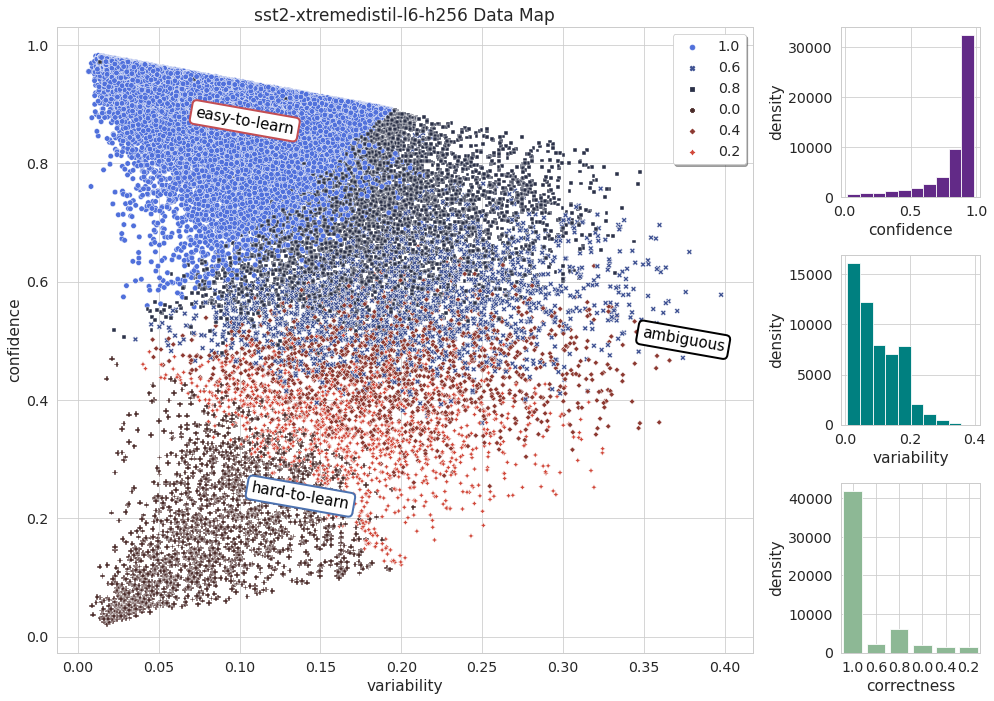

In [ ]:
class Args:
    model_dir = "/tmp/sst2"
    burn_out = 5
    task_name = "sst2"
    plots_dir = "sst2-plots"
    model = "xtremedistil-l6-h256"
    include_ci = False

args = Args()

training_dynamics = read_training_dynamics(args.model_dir,
                                            strip_last=True if args.task_name in ["QNLI"] else False,
                                            burn_out=args.burn_out if args.burn_out < 100 else None)
total_epochs = len(list(training_dynamics.values())[0]["logits"])
if args.burn_out > total_epochs:
    args.burn_out = total_epochs
print(f"Total epochs found: {args.burn_out}")
train_dy_metrics, _ = compute_train_dy_metrics(training_dynamics, args)

burn_out_str = f"_{args.burn_out}" if args.burn_out > total_epochs else ""
train_dy_filename = os.path.join(args.model_dir, f"td_metrics{burn_out_str}.jsonl")
train_dy_metrics.to_json(train_dy_filename,
                        orient='records',
                        lines=True)
print(f"Metrics based on Training Dynamics written to {train_dy_filename}")


if not os.path.exists(args.plots_dir):
    os.makedirs(args.plots_dir)
plot_data_map(train_dy_metrics, args.plots_dir, title=args.task_name, show_hist=True, model=args.model)

# Looking at some actual examples

sst2 contains little snippets from movie reviews with an associated sentiment

In [ ]:
from datasets import load_dataset


ds = load_dataset("glue", "sst2")

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

## These are the hardest to learn, potentially because they are mislabeled

The predictions for these examples are consistently wrong and the model is not confident at all.

In [ ]:
low_variability = train_dy_metrics["variability"] < 0.1
low_confidence = train_dy_metrics["confidence"] < 0.2
low_correctness = train_dy_metrics["correctness"] < 0.25

hardest_to_learn = train_dy_metrics[low_variability&low_confidence&low_correctness]

hardest_to_learn_ids = set(hardest_to_learn.guid)
hard_examples = ds["train"].filter(lambda x: x["idx"] in hardest_to_learn_ids)

hard_examples[:5]

  0%|          | 0/68 [00:00<?, ?ba/s]

{'idx': [466, 920, 1763, 1896, 3382],
 'label': [0, 0, 0, 1, 1],
 'sentence': ['as bestial ',
  'come close to the level of intelligence and visual splendor that can be seen in other films ',
  'construct a story with even a trace of dramatic interest ',
  "missing from the girls ' big-screen blowout ",
  'bitter nor sweet ']}

## These are the easiest to learn

The model gets these right every time and has high confidence predicting them. 

In [ ]:
low_variability = train_dy_metrics["variability"] < 0.05
high_confidence = train_dy_metrics["confidence"] > 0.95
high_correctness = train_dy_metrics["correctness"] > 0.9

easiest_to_learn = train_dy_metrics[low_variability&high_confidence&high_correctness]

easiest_to_learn_ids = set(easiest_to_learn.guid)
easy_examples = ds["train"].filter(lambda x: x["idx"] in easiest_to_learn_ids)

easy_examples[:5]

  0%|          | 0/68 [00:00<?, ?ba/s]

{'idx': [1, 2, 5, 13, 17],
 'label': [0, 1, 0, 0, 1],
 'sentence': ['contains no wit , only labored gags ',
  'that loves its characters and communicates something rather beautiful about human nature ',
  "that 's far too tragic to merit such superficial treatment ",
  'saw how bad this movie was ',
  'with his usual intelligence and subtlety ']}